# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

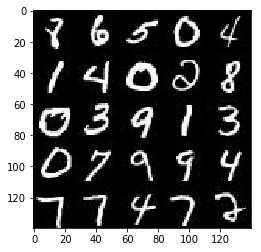

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

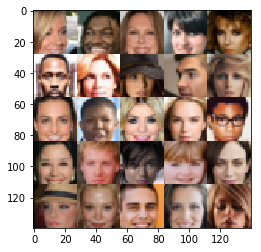

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/arthur_caillau/anaconda3/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    lr = tf.placeholder(tf.float32)
    
    return real_input, z_input, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input Layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=initializer)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=initializer)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        dropout2 = tf.layers.dropout(bn2, rate=0.8)
        relu2 = tf.maximum(alpha * dropout2, dropout2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=initializer)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        dropout3 = tf.layers.dropout(bn3, rate=0.8)
        relu3 = tf.maximum(alpha * dropout3, dropout3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=initializer)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.layers.dropout(x1, rate=0.5)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.layers.dropout(x2, rate=0.5)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.layers.dropout(x3, rate=0.5)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Adding an Extra Layer
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.layers.dropout(x4, rate=0.5)
        x4 = tf.maximum(alpha * x4, x4)
        # 32x32x64 now
        
        # Output layer
        logits = tf.layers.conv2d(x4, out_channel_dim, 5, strides=1, padding='valid')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real) * (1.0 - smooth) 
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    def scale_range (input, min=-1, max=1):
        """
        Scale numpy array `input` in-place
        """
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        
        return input

    samples, losses = [], []
    steps = 0
    
    # Building the NN
    real_input, z_input, lr = model_inputs(
        data_shape[1], 
        data_shape[2], 
        data_shape[3], 
        z_dim
    )
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Rescale batch_images to [-1, 1]
                batch_images = scale_range(batch_images)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                # Run the generator opt twice as often so that the discriminator loss does not go to zero
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 250 == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.2142... Generator Loss: 0.0160
Epoch 1/2... Discriminator Loss: 2.9520... Generator Loss: 0.1486
Epoch 1/2... Discriminator Loss: 2.0430... Generator Loss: 0.3605
Epoch 1/2... Discriminator Loss: 2.4613... Generator Loss: 0.2142
Epoch 1/2... Discriminator Loss: 2.3669... Generator Loss: 0.2552
Epoch 1/2... Discriminator Loss: 1.8838... Generator Loss: 0.3108
Epoch 1/2... Discriminator Loss: 1.8660... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.9066... Generator Loss: 0.4226
Epoch 1/2... Discriminator Loss: 1.6814... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 1.8452... Generator Loss: 0.3514
Epoch 1/2... Discriminator Loss: 1.8668... Generator Loss: 0.3226
Epoch 1/2... Discriminator Loss: 1.5048... Generator Loss: 0.7330
Epoch 1/2... Discriminator Loss: 1.7340... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 1.6827... Generator Loss: 0.4068
Epoch 1/2... Discriminator Loss: 1.6672... Generator Loss: 0.4500
Epoch 1/2.

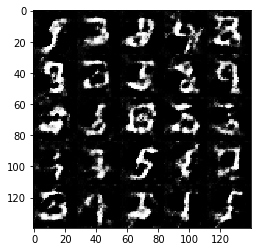

Epoch 1/2... Discriminator Loss: 1.6092... Generator Loss: 1.0805
Epoch 1/2... Discriminator Loss: 1.5990... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.5494... Generator Loss: 0.6245
Epoch 1/2... Discriminator Loss: 1.5985... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 1.5637... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.8122
Epoch 1/2... Discriminator Loss: 1.4914... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.5271... Generator Loss: 0.6051
Epoch 1/2... Discriminator Loss: 1.5715... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 1.5088... Generator Loss: 0.9705
Epoch 1/2... Discriminator Loss: 1.5427... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.6251
Epoch 1/2... Discriminator Loss: 1.5837... Generator Loss: 0.4877
Epoch 1/2... Discriminator Loss: 1.7386... Generator Loss: 0.3432
Epoch 1/2.

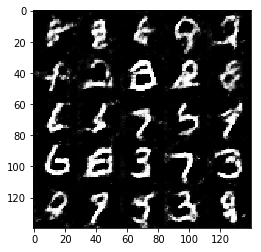

Epoch 1/2... Discriminator Loss: 1.4602... Generator Loss: 0.7196
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 1.5894... Generator Loss: 0.5689
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 0.5807
Epoch 1/2... Discriminator Loss: 1.6026... Generator Loss: 0.4037
Epoch 1/2... Discriminator Loss: 1.5547... Generator Loss: 0.4546
Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 0.5857
Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 0.8355
Epoch 1/2... Discriminator Loss: 1.5620... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.6397
Epoch 1/2... Discriminator Loss: 1.5320... Generator Loss: 0.4878
Epoch 1/2... Discriminator Loss: 1.5762... Generator Loss: 0.4542
Epoch 1/2... Discriminator Loss: 1.4945... Generator Loss: 0.7749
Epoch 1/2.

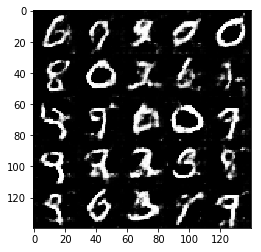

Epoch 1/2... Discriminator Loss: 1.4419... Generator Loss: 0.9815
Epoch 1/2... Discriminator Loss: 1.4288... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 1.4990... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 1.5385... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.4971... Generator Loss: 0.5306
Epoch 1/2... Discriminator Loss: 1.4700... Generator Loss: 0.5660
Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 0.4921
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.7283
Epoch 1/2... Discriminator Loss: 1.4992... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.4715... Generator Loss: 0.6134
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.6428
Epoch 1/2.

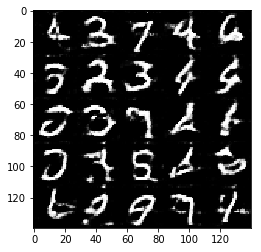

Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 1.1127
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.4958... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 1.4387... Generator Loss: 0.7318
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.9438
Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.6912
Epoch 1/2... Discriminator Loss: 1.4203... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.4460
Epoch 1/2.

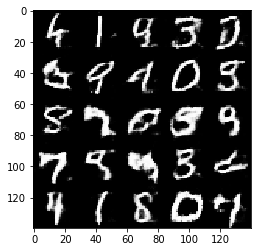

Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 1.0616
Epoch 1/2... Discriminator Loss: 1.3702... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.4925... Generator Loss: 0.6212
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.5121... Generator Loss: 0.9211
Epoch 1/2... Discriminator Loss: 1.4836... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.6244... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.8750
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 1.4625... Generator Loss: 0.5807
Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.8892
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.6945... Generator Loss: 0.3887
Epoch 1/2.

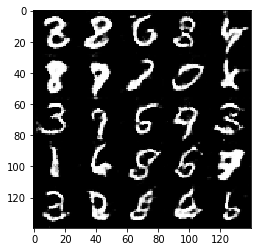

Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 1.7292... Generator Loss: 0.3675
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 0.6510
Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.5623
Epoch 1/2... Discriminator Loss: 1.3785... Generator Loss: 0.6500
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 0.5066
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.6555
Epoch 1/2... Discriminator Loss: 1.4728... Generator Loss: 1.3739
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.9534
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.6723
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.4531
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.6813... Generator Loss: 0.3507
Epoch 1/2.

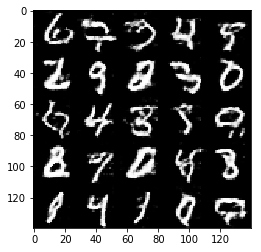

Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.5451... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.4765... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 1.4015... Generator Loss: 0.5594
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.5189
Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 1.4484... Generator Loss: 1.0705
Epoch 1/2... Discriminator Loss: 1.4418... Generator Loss: 0.6217
Epoch 1/2... Discriminator Loss: 1.5201... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 1.4679... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.4172
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 1.2205
Epoch 2/2.

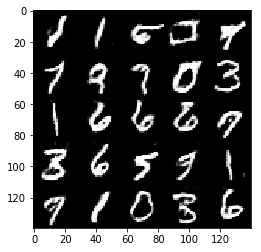

Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.5679
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.3492... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.8930
Epoch 2/2... Discriminator Loss: 1.4603... Generator Loss: 0.5409
Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.5781... Generator Loss: 1.2046
Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.9425
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.5184
Epoch 2/2... Discriminator Loss: 1.5183... Generator Loss: 1.0159
Epoch 2/2... Discriminator Loss: 1.4705... Generator Loss: 0.5981
Epoch 2/2... Discriminator Loss: 1.4269... Generator Loss: 0.7303
Epoch 2/2... Discriminator Loss: 1.4468... Generator Loss: 0.5685
Epoch 2/2... Discriminator Loss: 1.4164... Generator Loss: 0.9164
Epoch 2/2.

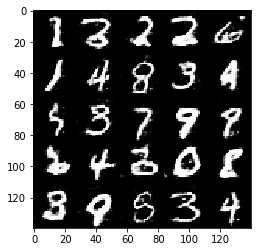

Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 1.4258... Generator Loss: 0.6446
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 1.2781
Epoch 2/2... Discriminator Loss: 1.8592... Generator Loss: 0.2806
Epoch 2/2... Discriminator Loss: 1.3806... Generator Loss: 0.5950
Epoch 2/2... Discriminator Loss: 1.6725... Generator Loss: 0.3668
Epoch 2/2... Discriminator Loss: 1.4398... Generator Loss: 0.6151
Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.4952... Generator Loss: 0.4782
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 0.7628
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.5939
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 1.6354... Generator Loss: 1.2969
Epoch 2/2... Discriminator Loss: 1.4847... Generator Loss: 0.4573
Epoch 2/2... Discriminator Loss: 1.4300... Generator Loss: 0.6155
Epoch 2/2.

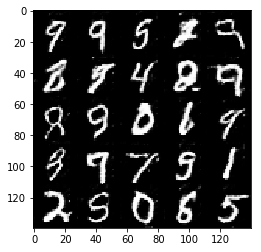

Epoch 2/2... Discriminator Loss: 1.5676... Generator Loss: 0.4147
Epoch 2/2... Discriminator Loss: 1.6144... Generator Loss: 0.3993
Epoch 2/2... Discriminator Loss: 1.7907... Generator Loss: 0.3056
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.8452
Epoch 2/2... Discriminator Loss: 1.5836... Generator Loss: 0.4105
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.6353
Epoch 2/2... Discriminator Loss: 1.5707... Generator Loss: 0.5389
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 1.0502
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.6556
Epoch 2/2... Discriminator Loss: 1.4124... Generator Loss: 0.6006
Epoch 2/2... Discriminator Loss: 1.2277... Generator Loss: 0.8760
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.5063
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 1.0084
Epoch 2/2... Discriminator Loss: 1.2318... Generator Loss: 0.8990
Epoch 2/2.

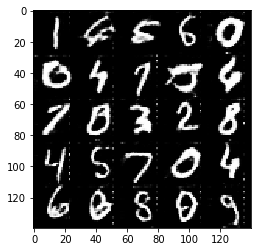

Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.5007
Epoch 2/2... Discriminator Loss: 1.0964... Generator Loss: 0.8519
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.4804
Epoch 2/2... Discriminator Loss: 1.3996... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 0.6838
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.5374
Epoch 2/2... Discriminator Loss: 1.1080... Generator Loss: 0.9754
Epoch 2/2... Discriminator Loss: 1.5918... Generator Loss: 0.8684
Epoch 2/2... Discriminator Loss: 1.1594... Generator Loss: 0.8795
Epoch 2/2... Discriminator Loss: 1.3686... Generator Loss: 1.0516
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.5055
Epoch 2/2... Discriminator Loss: 1.7066... Generator Loss: 0.3319
Epoch 2/2... Discriminator Loss: 1.2827... Generator Loss: 0.6899
Epoch 2/2... Discriminator Loss: 1.6879... Generator Loss: 1.7379
Epoch 2/2... Discriminator Loss: 1.3955... Generator Loss: 0.5223
Epoch 2/2.

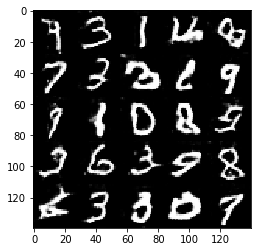

Epoch 2/2... Discriminator Loss: 1.3346... Generator Loss: 0.5252
Epoch 2/2... Discriminator Loss: 1.4914... Generator Loss: 0.4328
Epoch 2/2... Discriminator Loss: 1.3116... Generator Loss: 0.6434
Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 0.9418
Epoch 2/2... Discriminator Loss: 1.6228... Generator Loss: 0.3933
Epoch 2/2... Discriminator Loss: 1.5838... Generator Loss: 0.4196
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.6583
Epoch 2/2... Discriminator Loss: 1.4626... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 1.5203... Generator Loss: 0.7764
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.6252
Epoch 2/2... Discriminator Loss: 1.2983... Generator Loss: 0.7818
Epoch 2/2... Discriminator Loss: 0.8875... Generator Loss: 1.2707
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.7747
Epoch 2/2... Discriminator Loss: 1.7160... Generator Loss: 0.3440
Epoch 2/2... Discriminator Loss: 1.5893... Generator Loss: 0.3911
Epoch 2/2.

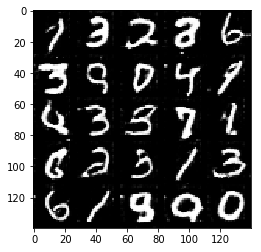

Epoch 2/2... Discriminator Loss: 1.6257... Generator Loss: 0.4110
Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.4553... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.7559
Epoch 2/2... Discriminator Loss: 1.1896... Generator Loss: 0.8481
Epoch 2/2... Discriminator Loss: 1.2640... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 1.1179
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 1.0710
Epoch 2/2... Discriminator Loss: 1.7025... Generator Loss: 0.3604
Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 1.0999
Epoch 2/2... Discriminator Loss: 1.4838... Generator Loss: 0.5078
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.5291
Epoch 2/2... Discriminator Loss: 1.4624... Generator Loss: 0.5051
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.4398
Epoch 2/2.

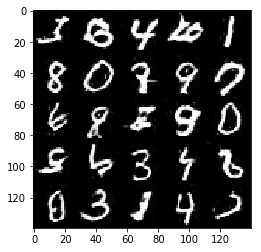

Epoch 2/2... Discriminator Loss: 1.6857... Generator Loss: 0.3435
Epoch 2/2... Discriminator Loss: 1.4849... Generator Loss: 0.4735
Epoch 2/2... Discriminator Loss: 2.0972... Generator Loss: 0.2099
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.7213
Epoch 2/2... Discriminator Loss: 1.6296... Generator Loss: 0.3765
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.5952
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.5677
Epoch 2/2... Discriminator Loss: 1.4887... Generator Loss: 0.4943
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.5120
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 1.5260... Generator Loss: 0.4641
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 0.7966
Epoch 2/2... Discriminator Loss: 1.4885... Generator Loss: 0.5602
Epoch 2/2... Discriminator Loss: 1.6360... Generator Loss: 0.3558
Epoch 2/2.

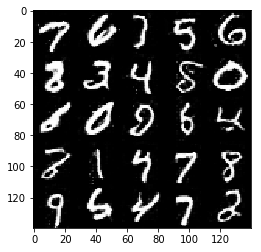

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        mnist_dataset.get_batches,
        mnist_dataset.shape, 
        mnist_dataset.image_mode
    )

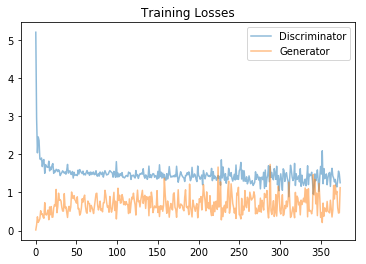

In [13]:
# Plot losses
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4562... Generator Loss: 1.4276
Epoch 1/1... Discriminator Loss: 2.4645... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 2.0762... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 1.9562... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 2.2350... Generator Loss: 0.3582
Epoch 1/1... Discriminator Loss: 1.8736... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.9459... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 1.7684... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.7935... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.6849... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.6965... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.8418... Generator Loss: 0.4956
Epoch 1/1... Discriminator Loss: 1.8996... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.6313
Epoch 1/1.

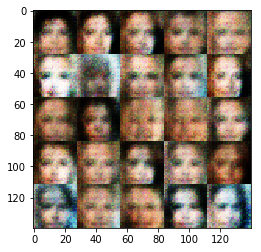

Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6861
Epoch 1/1.

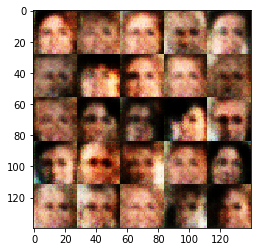

Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 1.0506
Epoch 1/1.

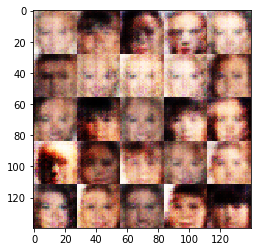

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.7482
Epoch 1/1.

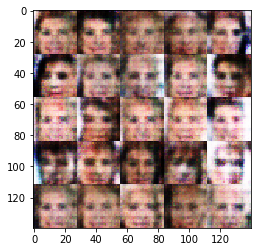

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6093
Epoch 1/1.

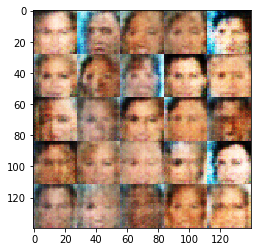

Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7790
Epoch 1/1.

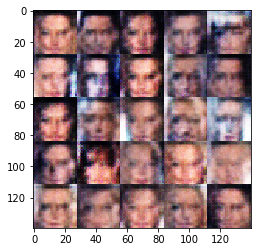

Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7782
Epoch 1/1.

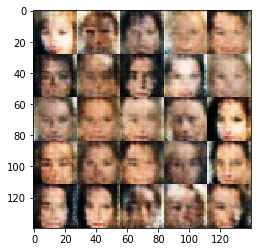

Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7102
Epoch 1/1.

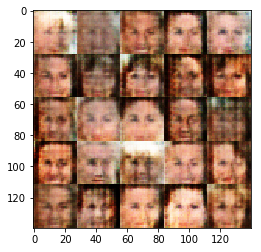

Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6630
Epoch 1/1.

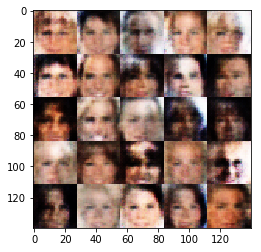

Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7890
Epoch 1/1.

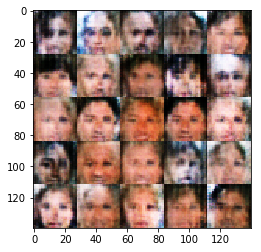

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7978
Epoch 1/1.

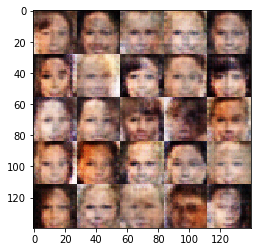

Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.8482
Epoch 1/1.

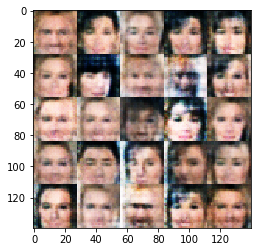

Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7453
Epoch 1/1.

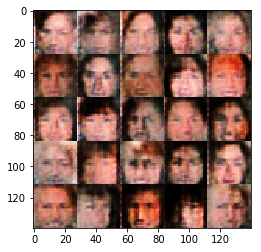

Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7411
Epoch 1/1.

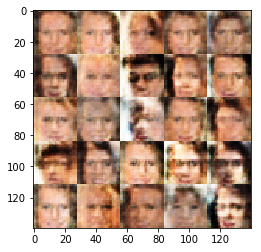

Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7060
Epoch 1/1.

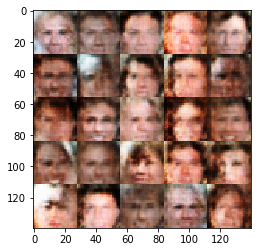

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.4713
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7103
Epoch 1/1.

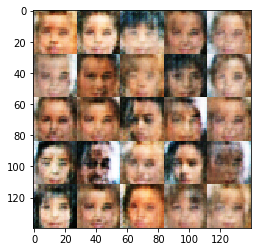

Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7811
Epoch 1/1.

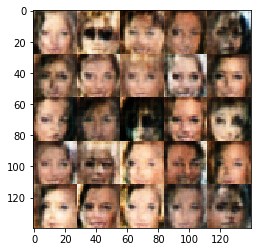

Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7970
Epoch 1/1.

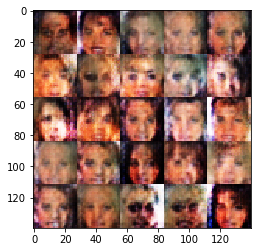

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.5968
Epoch 1/1.

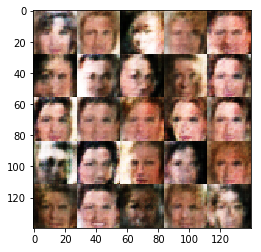

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7262
Epoch 1/1.

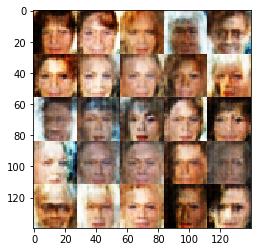

Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7106
Epoch 1/1.

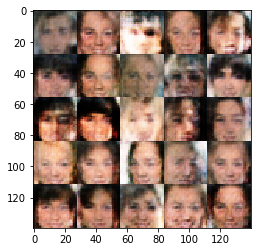

Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6972
Epoch 1/1.

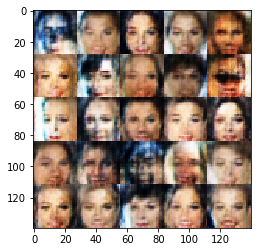

Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8353
Epoch 1/1.

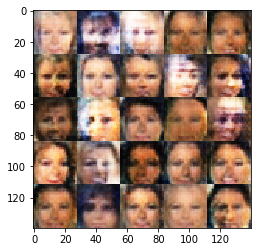

Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7399
Epoch 1/1.

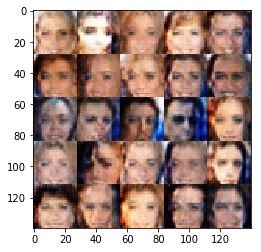

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7998
Epoch 1/1.

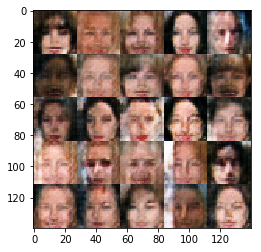

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7276


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(
        epochs, 
        batch_size, 
        z_dim, 
        learning_rate, 
        beta1, 
        celeba_dataset.get_batches,
        celeba_dataset.shape, 
        celeba_dataset.image_mode
    )

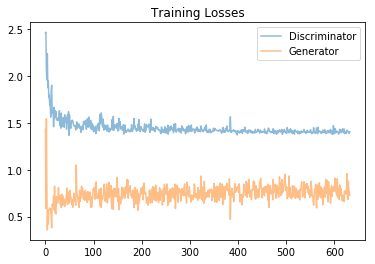

In [15]:
# Plot losses
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.